# Assignment 2: recommender System

In [2]:
#get data from GitHub -> https://github.com/keuperj/DATA
!git clone https://github.com/keuperj/DATA.git

Cloning into 'DATA'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 101 (delta 2), reused 14 (delta 2), pack-reused 87
Receiving objects: 100% (101/101), 146.44 MiB | 22.35 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Updating files: 100% (69/69), done.


## Code from the lecture

In [4]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [5]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [6]:
epsilon=0.0000001 
def CosineDist(a,b):
    return a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b)+epsilon) #added epsilon for numerical stability: avoiding div by zero -> NaN

In [7]:
%%time
#again, implementation not efficient: better use lamda opperators 
D=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D[i,j]=CosineDist(R[:,i],R[:,j])

CPU times: user 2min, sys: 331 ms, total: 2min
Wall time: 2min 2s


In [8]:
def getTopN(movie_id, D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title, D):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title),D))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [9]:
#test score of Movie ID 0
Score_byID(0,D,R)

(array([ 49, 180, 120, 116, 404]),
 49                  Star Wars (1977)
 180        Return of the Jedi (1983)
 120    Independence Day (ID4) (1996)
 116                 Rock, The (1996)
 404       Mission: Impossible (1996)
 Name: title, dtype: object,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [3., 0., 2., ..., 0., 0., 0.],
        [4., 0., 0., ..., 0., 0., 0.],
        [4., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]]),
 0.31985731272294887)

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

In [10]:
#split into train and test data (code from lecture notebook)
from sklearn.model_selection import train_test_split
R_train, R_test = train_test_split(R, test_size=0.1)

In [11]:
#compute D for cosine with train data (code from lecture)
D_cosine=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D_cosine[i,j]=CosineDist(R_train[:,i],R_train[:,j])

In [12]:
#run test for cosine train
test_cosine=test_Score(D_cosine,R_test)

In [13]:
#get mean recommendation value of cosine dist
np.mean(test_cosine)

2.248421052631579

In [14]:
#define new dist function
def MyDist(a,b):
    return np.sum(np.abs(a-b)) 

In [15]:
#compute D for MyDist with train data (code from lecture)
D_my=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D_my[i,j]=MyDist(R_train[:,i],R_train[:,j])

In [16]:
D_my

array([[   0., 1381., 1434., ..., 1558., 1553., 1553.],
       [1381.,    0.,  471., ...,  379.,  374.,  374.],
       [1434.,  471.,    0., ...,  246.,  247.,  241.],
       ...,
       [1558.,  379.,  246., ...,    0.,    5.,    5.],
       [1553.,  374.,  247., ...,    5.,    0.,    6.],
       [1553.,  374.,  241., ...,    5.,    6.,    0.]])

In [17]:
#run test for cosine train
test_my=test_Score(D_my,R_test)

In [18]:
#get mean recommendation value of my dist
np.mean(test_my)

1.5195789473684207

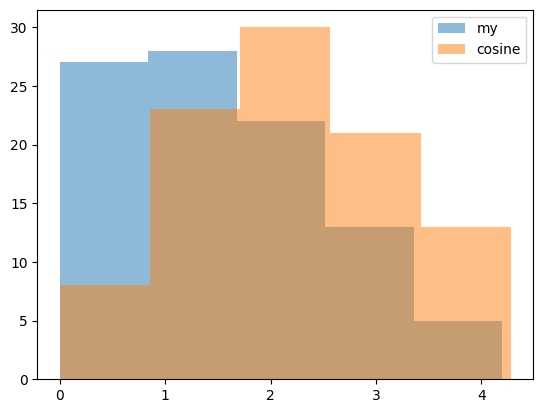

In [19]:
#plot hist over D versions
plt.hist(test_my,bins=5,label='my',alpha=0.5)
plt.hist(test_cosine,bins=5,label='cosine',alpha=0.5) #alpha sets transperency
plt.legend()

## 4.2 Baseline Results
Implement and compare results of two very simple baseline methods 
* random recommendations: randomly recommend 5 movies (HINT user np.random sub-library to generate random movie IDs)
* always recommending the top 5 movies: HINT: need to find the IDs of the top 5 movies over all users first

In [20]:
#get random movie IDs
id_rand=np.random.randint(np.shape(R)[0],size=5) # 5 rand samples from the number of movies
id_rand

array([751,  58, 192, 468, 713])

In [21]:
#get top 5 movies
id_top5=np.argsort(np.sum(R,axis=0))[-5:]#sum over all ratings along the movie axis, sort it and retun last 5
id_top5

array([173, 257, 180,  99,  49])

In [22]:
#now we need to change the eval functions - we do not need a D and do not neet to compute res_id, we have fixed reconnedatons (a vector of 5 IDs)
def Score_byID(ID, res_id, Test):
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users - res_id is the list of recommended IDs
def test_Score(res_id, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,res_id, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [23]:
test_rand=test_Score(id_rand,R_test)
test_top5=test_Score(id_top5,R_test)

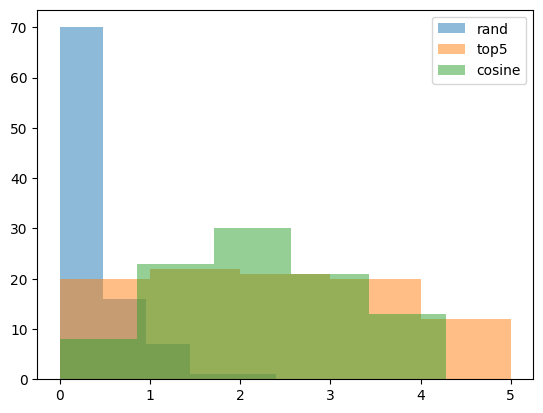

In [24]:
#plot hist over D_cosine and D_250 
plt.hist(test_rand,bins=5,label='rand',alpha=0.5)
plt.hist(test_top5,bins=5,label='top5',alpha=0.5)
plt.hist(test_cosine,bins=5,label='cosine',alpha=0.5) #alpha sets transperency
plt.legend()

## 4.3 SVD (with NumPy - not part of the assignment)
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $D$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct and evaluate $D'$


In [25]:
U,S,V=np.linalg.svd(D_cosine)

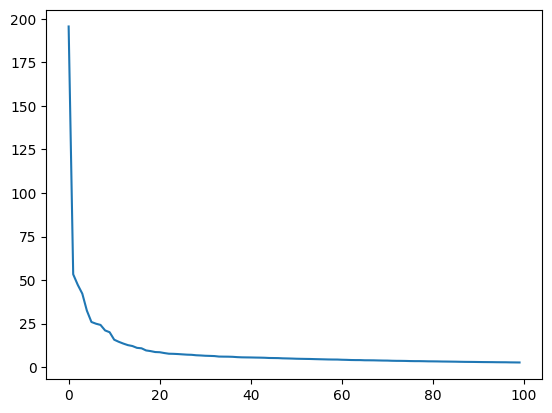

In [26]:
#plot the sigular values
plt.plot(S[:100])

In [27]:
np.allclose(D_cosine, np.dot(U * S, V)) #check if reconstruction is close to original

True

In [28]:
#now with reduced number of singular values

#top 10
D_10 = np.dot(U[:,:10]*S[:10],V[:10,:])
np.allclose(D_cosine, D_10)

False

In [29]:
np.sum(np.abs(D_cosine-D_10))/D.size #average error per entry

0.02645837468066416

In [30]:
#top 250
D_250 = np.dot(U[:,:250]*S[:250],V[:250,:])
np.allclose(D_cosine, D_250)

False

In [31]:
np.sum(np.abs(D_cosine-D_250))/D.size #average error per entry


0.007890967838031851

In [32]:
#run test for D_250
test_250=test_Score(D_250,R_test)

IndexError: ignored

In [33]:
#plot hist over D_cosine and D_250 
plt.hist(test_250,bins=5,label='250',alpha=0.5)
plt.hist(test_cosine,bins=5,label='cosine',alpha=0.5) #alpha sets transperency
plt.legend()

NameError: ignored

In [ ]:
# Results are even better! - why? -> removing noise (see over fitting in Block 4)

In [ ]:
np.mean(test_250)